In [1]:
!pip install geocoder
!pip install folium
!pip install geopy

In [2]:
import pandas as pd
import numpy as np
import geocoder
import requests
import folium
import matplotlib.cm as cm
import matplotlib.colors as colors
import json
import xml
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

from pandas.io.json import json_normalize 
from sklearn.cluster import KMeans
from geopy.geocoders import Nominatim 

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

print("All Required Libraries Imported!")

All Required Libraries Imported!


In [3]:
df = pd.read_excel (r'/Users/prakshi/Downloads/Chicago.xlsx')
print(df.shape)
df.head()

(246, 2)


,Community Area,Neighborhood
0,Albany Park,Albany Park
1,Albany Park,Mayfair
2,Albany Park,North Mayfair
3,Albany Park,Ravenswood Manor
4,Archer Heights,Archer Heights


In [4]:
def get_latilong(neighborhood):
    lati_long_coords = None
    while(lati_long_coords is None):
        g = geocoder.arcgis('{}, Chicago, Illinois'.format(neighborhood))
        lati_long_coords = g.latlng
    return lati_long_coords
    
get_latilong('Galewood')

[41.92362000000003, -87.79250999999994]

In [5]:
neighborhoods = df['Neighborhood']
coords = [ get_latilong(neighborhood) for neighborhood in neighborhoods.tolist() ]

In [6]:
df_coords = pd.DataFrame(coords, columns=['Latitude', 'Longitude'])
df['Latitude'] = df_coords['Latitude']
df['Longitude'] = df_coords['Longitude']
df.head()

,Community Area,Neighborhood,Latitude,Longitude
0,Albany Park,Albany Park,41.96829,-87.723380
1,Albany Park,Mayfair,41.96793,-87.737880
2,Albany Park,North Mayfair,41.97351,-87.742160
3,Albany Park,Ravenswood Manor,41.97840,-87.675073
4,Archer Heights,Archer Heights,41.81154,-87.725560


In [7]:
df[df.Neighborhood == 'Crestline']

,Community Area,Neighborhood,Latitude,Longitude
8,Ashburn,Crestline,41.744278,-87.725217


In [8]:
address = 'Chicago,Illinois'

geolocator = Nominatim(user_agent="myemailaddress@gmail.com")
location = geolocator.geocode(address)
latitude_x = location.latitude
longitude_y = location.longitude
print('The Geograpical Co-ordinate of Chicago, Illinois are {}, {}.'.format(latitude_x, longitude_y))

The Geograpical Co-ordinate of Chicago, Illinois are 41.8755616, -87.6244212.


In [9]:
chicago_map = folium.Map(location=[latitude_x, longitude_y], zoom_start=10)

for lat, lng, nei in zip(df['Latitude'], df['Longitude'], df['Neighborhood']):
    
    label = '{}'.format(nei)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(chicago_map)  
    
chicago_map

In [10]:
address = 'Chicago,Illinois'

geolocator = Nominatim(user_agent="myemailaddress@gmail.com")
location = geolocator.geocode(address)
latitude_n1 = location.latitude
longitude_n1 = location.longitude
print('The Geograpical Co-ordinate of Neighborhood are {}, {}.'.format(latitude_x, longitude_y))

The Geograpical Co-ordinate of Neighborhood are 41.8755616, -87.6244212.


In [11]:
CLIENT_ID = 'My Foursquare Client ID'
CLIENT_SECRET = 'My Foursquare Client Secret'
VERSION = '20180604'
LIMIT = 30

In [12]:
radius = 700 
LIMIT = 100
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    latitude_n1, 
   longitude_n1, 
    radius, 
   LIMIT)
results = requests.get(url).json()

In [13]:
venues=results['response']['groups'][0]['items']
nearby_venues = json_normalize(venues)
nearby_venues.columns

Index(['referralId', 'reasons.count', 'reasons.items', 'venue.id',
       'venue.name', 'venue.location.address', 'venue.location.crossStreet',
       'venue.location.lat', 'venue.location.lng',
       'venue.location.labeledLatLngs', 'venue.location.distance',
       'venue.location.postalCode', 'venue.location.cc', 'venue.location.city',
       'venue.location.state', 'venue.location.country',
       'venue.location.formattedAddress', 'venue.categories',
       'venue.photos.count', 'venue.photos.groups', 'venue.venuePage.id',
       'venue.delivery.id', 'venue.delivery.url',
       'venue.delivery.provider.name', 'venue.delivery.provider.icon.prefix',
       'venue.delivery.provider.icon.sizes',
       'venue.delivery.provider.icon.name', 'venue.location.neighborhood'],
      dtype='object')

In [14]:
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [15]:
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]
nearby_venues.head()

,venue.name,venue.categories,venue.location.lat,venue.location.lng
0,Auditorium Theatre,"[{'id': '4bf58dd8d48988d137941735', 'name': 'T...",41.876058,-87.625303
1,Cafecito,"[{'id': '4bf58dd8d48988d154941735', 'name': 'C...",41.875724,-87.626386
2,Osaka Sushi Express & Fresh Fruit Smoothies,"[{'id': '4bf58dd8d48988d1d2941735', 'name': 'S...",41.876969,-87.624534
3,SummerDance,"[{'id': '4bf58dd8d48988d134941735', 'name': 'D...",41.873804,-87.623335
4,Fine Arts Building,"[{'id': '4bf58dd8d48988d1f1931735', 'name': 'G...",41.876511,-87.624234


In [16]:
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]
nearby_venues.head()

,name,categories,lat,lng
0,Auditorium Theatre,Theater,41.876058,-87.625303
1,Cafecito,Cuban Restaurant,41.875724,-87.626386
2,Osaka Sushi Express & Fresh Fruit Smoothies,Sushi Restaurant,41.876969,-87.624534
3,SummerDance,Dance Studio,41.873804,-87.623335
4,Fine Arts Building,General Entertainment,41.876511,-87.624234


In [17]:
a = pd.Series(nearby_venues.categories)
a.value_counts()[:10]

Coffee Shop            6
Pizza Place            5
Sandwich Place         4
Garden                 3
Hotel                  3
Taco Place             3
American Restaurant    3
Boutique               2
Bar                    2
Arts & Crafts Store    2
Name: categories, dtype: int64

In [18]:
def getNearbyVenues(names, latitudes, longitudes, radius=700):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        venue_results = requests.get(url).json()["response"]['groups'][0]['items']
        
        venues_list.append([(
            name,
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in venue_results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [19]:
chicago_venues = getNearbyVenues(names=df['Neighborhood'],latitudes=df['Latitude'],longitudes=df['Longitude'])

Albany Park
Mayfair
North Mayfair
Ravenswood Manor
Archer Heights
Chinatown
Armour Square
Wentworth Gardens
Crestline
Ashburn
Beverly View
Ashburn Estates
Parkview
Scottsdale
Wrightwood
Auburn Gresham
Gresham
Galewood
The Island
North Austin
South Austin
West Humboldt Park
Avalon Park
Marynook
Stony Island Park
Avondale
Jackowo
Wacławowo
Polish Village
Belmont Central
Cragin
Brickyard
Hanson Park
East Beverly
Beverly
West Beverly
Bridgeport
Brighton Park
Burnside
Calumet Heights
Pill Hill
Chatham
East Chatham
West Chatham
West Chesterfield
Chicago Lawn
Lithuanian Plaza
Marquette Park
Chrysler Village
Clearing East
Clearing West
The Gap
Bronzeville
Dearborn Homes
Groveland Park
Lake Meadows
Prairie Shores
South Commons
Stateway Gardens
Dunning
Belmont Heights
Belmont Terrace
Irving Woods
Schorsch Village
East Garfield Park
Fifth City
East Side
Edgewater Glen
Andersonville
Edgewater
Edgewater Beach
Lakewood / Balmoral
Edison Park
Englewood
Hamilton Park
Forest Glen
Edgebrook
Old Edgebroo

In [20]:
print('There are {} Uniques Categories.'.format(len(chicago_venues['Venue Category'].unique())))
chicago_venues.groupby('Neighborhood').count().head()

There are 409 Uniques Categories.


,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Albany Park,34,34,34,34,34,34
Altgeld Gardens,3,3,3,3,3,3
Andersonville,77,77,77,77,77,77
Archer Heights,29,29,29,29,29,29
Armour Square,41,41,41,41,41,41


In [21]:
chicago_onehot = pd.get_dummies(chicago_venues[['Venue Category']], prefix="", prefix_sep="")
chicago_onehot['Neighborhood'] = chicago_venues['Neighborhood'] 
fixed_columns = [chicago_onehot.columns[-1]] + list(chicago_onehot.columns[:-1])
chicago_onehot = chicago_onehot[fixed_columns]
chicago_grouped = chicago_onehot.groupby('Neighborhood').mean().reset_index()
chicago_onehot.head()

,Neighborhood,ATM,Accessories Store,Adult Boutique,Afghan Restaurant,African Restaurant,Airport,Airport Food Court,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Amphitheater,Animal Shelter,Antique Shop,Arcade,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Arts & Entertainment,Asian Restaurant,Athletics & Sports,Auto Dealership,Auto Garage,Auto Workshop,Automotive Shop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Court,Bavarian Restaurant,Beach,Bed & Breakfast,Beer Bar,Beer Garden,Beer Store,Big Box Store,Bike Rental / Bike Share,Bike Shop,Bike Trail,Bistro,Board Shop,Boat or Ferry,Bookstore,Border Crossing,Boutique,Bowling Alley,Boxing Gym,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bridge,Bubble Tea Shop,Buffet,Building,Burger Joint,Burmese Restaurant,Burrito Place,Bus Line,Bus Station,Bus Stop,Business Service,Butcher,Cafeteria,Café,Cajun / Creole Restaurant,Camera Store,Campground,Canal,Candy Store,Cantonese Restaurant,Caribbean Restaurant,Carpet Store,Casino,Check Cashing Service,Child Care Service,Chinese Restaurant,Chocolate Shop,Circus,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Arts Building,College Bookstore,College Cafeteria,College Gym,College Rec Center,College Stadium,Comedy Club,Comfort Food Restaurant,Comic Shop,Community Center,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Costume Shop,Creperie,Cruise Ship,Cuban Restaurant,Cupcake Shop,Currency Exchange,Cycle Studio,Czech Restaurant,Dance Studio,Deli / Bodega,Department Store,Design Studio,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distillery,Dive Bar,Doctor's Office,Dog Run,Donut Shop,Dry Cleaner,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Elementary School,Empanada Restaurant,Entertainment Service,Escape Room,Ethiopian Restaurant,Event Service,Event Space,Exhibit,Eye Doctor,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Financial or Legal Service,Fish & Chips Shop,Fish Market,Flea Market,Floating Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Stand,Food Truck,Football Stadium,Forest,Fountain,Frame Store,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,German Restaurant,Gift Shop,Go Kart Track,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Gymnastics Gym,Halal Restaurant,Harbor / Marina,Hardware Store,Hawaiian Restaurant,Health & Beauty Service,Health Food Store,Heliport,Hill,Historic Site,History Museum,Hobby Shop,Hockey Arena,Home Service,Hookah Bar,Hostel,Hot Dog Joint,Hotel,Hotel Bar,Hotel Pool,Hotpot Restaurant,IT Services,Ice Cream Shop,Indian Chinese Restaurant,Indian Restaurant,Indie Movie Theater,Indie Theater,Indoor Play Area,Insurance Office,Intersection,Irish Pub,Israeli Restaurant,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Karaoke Bar,Kids Store,Kitchen Supply Store,Korean Restaurant,Lake,Latin American Restaurant,Laundromat,Leather Goods Store,Library,Light Rail Station,Lighthouse,Lingerie Store,Liquor Store,Lounge,Mac & Cheese Joint,Malay Restaurant,Marijuana Dispensary,Market,Martial Arts School,Massage Studio,Mattress Store,Medical Center,Mediterranean Restaurant,Memorial Site,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Mini Golf,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Moroccan Restaurant,Motel,Motorcycle Shop,Movie Theater,Moving Target,Multiplex,Museum,Music Store,Music Venue,Nail Salon,National Park,Nature Preserve,New American Restaurant,Night Market,Nightclub,Nightlife Spot,Non-Profit,Noodle House,North Indian Restaurant,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Other Nightlife,Other

In [22]:
num_top_venues = 5
for hood in chicago_grouped['Neighborhood']:
    print("---- "+hood+" ----")
    temp = chicago_grouped[chicago_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

---- Albany Park ----
                venue  freq
0                Park  0.09
1         Pizza Place  0.06
2  Mexican Restaurant  0.06
3  Chinese Restaurant  0.06
4              Bakery  0.06


---- Altgeld Gardens ----
                  venue  freq
0                  Park  0.33
1         Grocery Store  0.33
2  Fast Food Restaurant  0.33
3                   ATM  0.00
4           Opera House  0.00


---- Andersonville ----
                venue  freq
0         Coffee Shop  0.06
1              Bakery  0.04
2      Breakfast Spot  0.04
3      Sandwich Place  0.04
4  Italian Restaurant  0.04


---- Archer Heights ----
                venue  freq
0  Seafood Restaurant  0.07
1   Mobile Phone Shop  0.07
2       Grocery Store  0.07
3    Department Store  0.03
4         Coffee Shop  0.03


---- Armour Square ----
              venue  freq
0  Baseball Stadium  0.12
1               Bar  0.07
2       Bus Station  0.05
3    Shipping Store  0.05
4            Lounge  0.05


---- Ashburn ----
           

4  Fried Chicken Joint  0.04


---- Grand Boulevard ----
                 venue  freq
0          Art Gallery  0.08
1                 Park  0.08
2  American Restaurant  0.08
3         Liquor Store  0.08
4       Breakfast Spot  0.04


---- Grand Crossing ----
                 venue  freq
0               Lounge  0.20
1                 Park  0.13
2        Train Station  0.13
3  Fried Chicken Joint  0.07
4              Theater  0.07


---- Greater Grand Crossing ----
                 venue  freq
0               Lounge  0.13
1         Liquor Store  0.09
2  Fried Chicken Joint  0.09
3    Currency Exchange  0.09
4    Convenience Store  0.09


---- Greektown ----
              venue  freq
0  Greek Restaurant  0.07
1       Coffee Shop  0.07
2       Pizza Place  0.04
3              Café  0.04
4        Restaurant  0.04


---- Gresham ----
                venue  freq
0  Mexican Restaurant  0.07
1       Grocery Store  0.05
2      Breakfast Spot  0.05
3                 Bar  0.05
4  Chinese Restaurant

4            Dive Bar  0.03


---- Pullman ----
            venue  freq
0             ATM  0.08
1   Train Station  0.08
2        Pharmacy  0.08
3  Sandwich Place  0.08
4            Park  0.08


---- Ranch Triangle ----
                 venue  freq
0            Hotel Bar  0.15
1  American Restaurant  0.10
2                Hotel  0.10
3           Restaurant  0.05
4        Metro Station  0.05


---- Ravenswood ----
                venue  freq
0  Mexican Restaurant  0.05
1         Coffee Shop  0.05
2         Pizza Place  0.05
3      Sandwich Place  0.04
4  Chinese Restaurant  0.04


---- Ravenswood Gardens ----
                venue  freq
0                 Bar  0.06
1             Brewery  0.04
2         Coffee Shop  0.04
3  Miscellaneous Shop  0.03
4      Sandwich Place  0.03


---- Ravenswood Manor ----
                venue  freq
0                 Bar  0.06
1             Brewery  0.04
2         Coffee Shop  0.04
3  Miscellaneous Shop  0.03
4      Sandwich Place  0.03


---- River North -

In [23]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [24]:
import numpy as np
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = chicago_grouped['Neighborhood']

for ind in np.arange(chicago_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(chicago_grouped.iloc[ind, :], num_top_venues)

print(neighborhoods_venues_sorted.shape)
neighborhoods_venues_sorted.head()

(246, 11)


,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Albany Park,Park,Bakery,Mexican Restaurant,Pizza Place,Chinese Restaurant,Donut Shop,Bank,Taco Place,Dive Bar,Fried Chicken Joint
1,Altgeld Gardens,Grocery Store,Park,Fast Food Restaurant,Eye Doctor,Electronics Store,Elementary School,Empanada Restaurant,Entertainment Service,Escape Room,Ethiopian Restaurant
2,Andersonville,Coffee Shop,Breakfast Spot,Sandwich Place,Italian Restaurant,Bakery,Grocery Store,Liquor Store,New American Restaurant,Shoe Store,Sushi Restaurant
3,Archer Heights,Mobile Phone Shop,Seafood Restaurant,Grocery Store,Mexican Restaurant,Optical Shop,Gas Station,Bar,Bank,Bakery,Big Box Store
4,Armour Square,Baseball Stadium,Bar,Sports Bar,Train Station,Bus Station,Sandwich Place,Lounge,Shipping Store,Baseball Field,Chinese Restaurant


In [25]:
chicago_grouped_clustering = chicago_grouped.drop('Neighborhood', 1)
kmeans = KMeans(n_clusters = 3, random_state = 0).fit(chicago_grouped_clustering)
kmeans.labels_

array([0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0,
       0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0,
       0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0], dtype=int32)

In [26]:
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)
chicago_merged = df.iloc[:246,:]
chicago_merged = chicago_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')
chicago_merged.head()

,Community Area,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Albany Park,Albany Park,41.96829,-87.723380,0,Park,Bakery,Mexican Restaurant,Pizza Place,Chinese Restaurant,Donut Shop,Bank,Taco Place,Dive Bar,Fried Chicken Joint
1,Albany Park,Mayfair,41.96793,-87.737880,0,Pizza Place,Middle Eastern Restaurant,Intersection,Seafood Restaurant,Gym,Korean Restaurant,Rental Car Location,Park,Design Studio,Campground
2,Albany Park,North Mayfair,41.97351,-87.742160,0,Filipino Restaurant,Middle Eastern Restaurant,Sandwich Place,Taco Place,Liquor Store,Donut Shop,Big Box Store,Mexican Restaurant,Paper / Office Supplies Store,Clothing Store
3,Albany Park,Ravenswood Manor,41.97840,-87.675073,0,Bar,Coffee Shop,Brewery,Bakery,Italian Restaurant,New American Restaurant,Massage Studio,Boutique,Breakfast Spot,Sandwich Place
4,Archer Heights,Archer Heights,41.81154,-87.725560,0,Mobile Phone Shop,Seafood Restaurant,Grocery Store,Mexican Restaurant,Optical Shop,Gas Station,Bar,Bank,Bakery,Big Box Store


In [27]:
kclusters = 10

In [28]:
map_clusters = folium.Map(location=[latitude_x, longitude_y], zoom_start=11)

x = np.arange(kclusters)
colors_array = cm.rainbow(np.linspace(0, 1, kclusters))
rainbow = [colors.rgb2hex(i) for i in colors_array]
print(rainbow)

markers_colors = []
for lat, lon, nei , cluster in zip(chicago_merged['Latitude'], 
                                   chicago_merged['Longitude'], 
                                   chicago_merged['Neighborhood'], 
                                   chicago_merged['Cluster Labels']):
    label = folium.Popup(str(nei) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

['#8000ff', '#4856fb', '#10a2f0', '#2adddd', '#62fbc4', '#9cfba4', '#d4dd80', '#ffa256', '#ff562c', '#ff0000']


In [29]:
chicago_avg_housing_price = pd.read_excel (r'/Users/prakshi/Downloads/Median Housing Prices By Community Area.xlsx')
chicago_avg_housing_price.head()

,Community Area,Median Housing Prices
0,Albany Park,306254
1,Archer Heights,359000
2,Armour Square,380000
3,Ashburn,610000
4,Auburn Gresham,202500


In [30]:
chicago_avg_housing_price.set_index('Community Area',inplace=True,drop=True)

<AxesSubplot:xlabel='Community Area'>

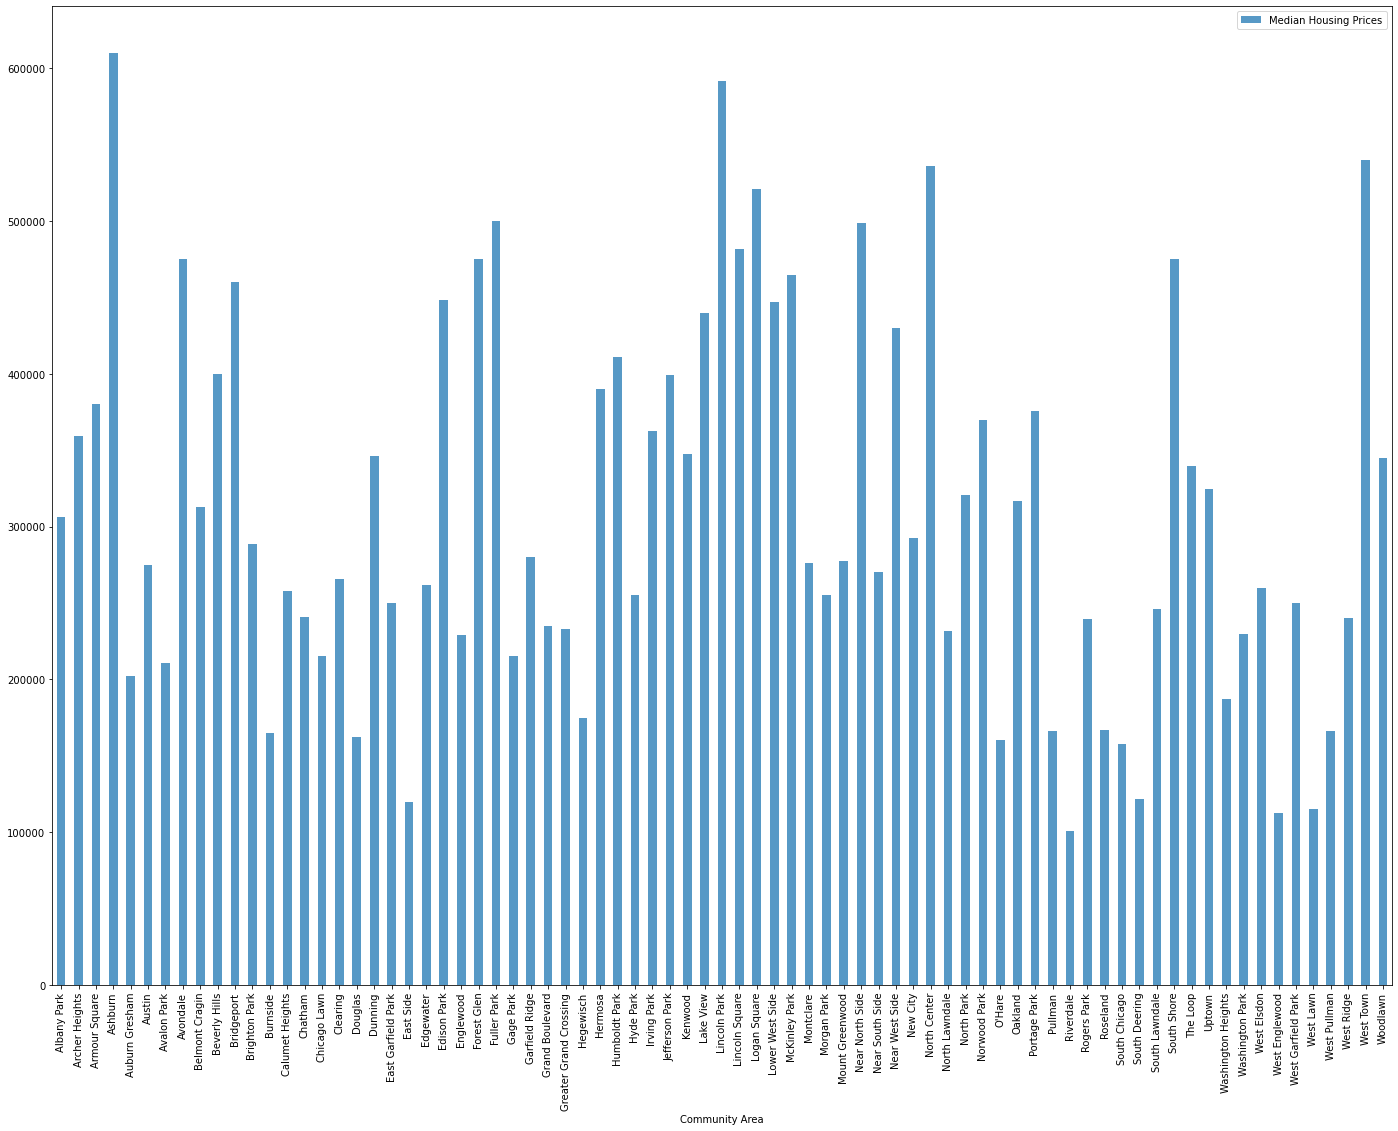

In [31]:
chicago_avg_housing_price.plot(kind='bar',figsize=(24,18),alpha=0.75)

In [32]:
chicago_school_ranking = pd.read_excel (r'/Users/prakshi/Downloads/Top School Ratings By Community Area.xlsx')
chicago_school_ranking.head()

,Community Area,Top School Ratings
0,Albany Park,8.0
1,Archer Heights,8.5
2,Armour Square,6.5
3,Ashburn,7.5
4,Auburn Gresham,7.0


In [33]:
chicago_school_ranking.set_index('Community Area',inplace=True,drop=True)

<AxesSubplot:xlabel='Community Area'>

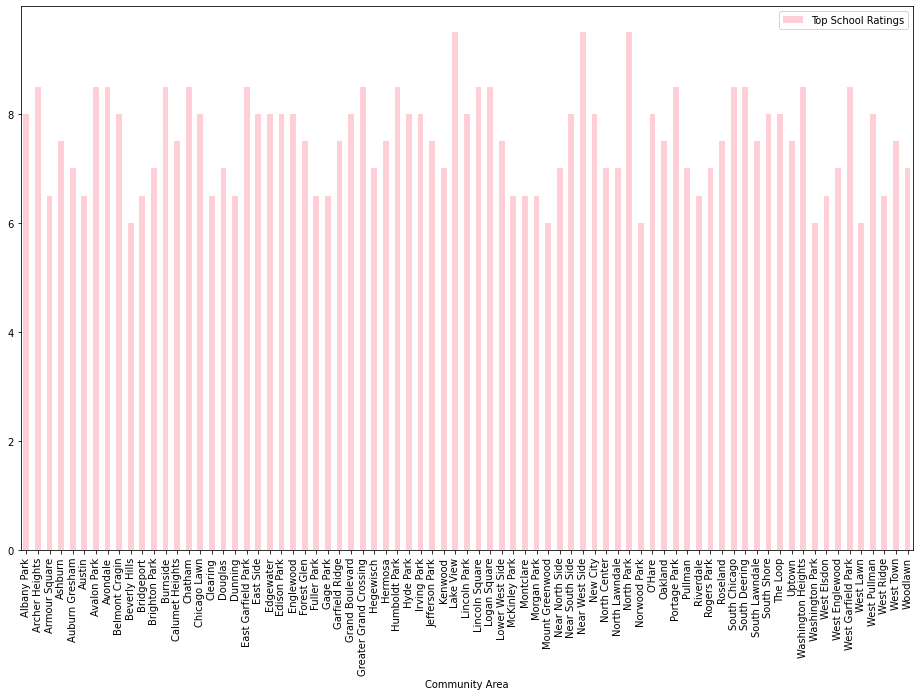

In [34]:
chicago_school_ranking.plot(kind='bar',figsize=(16,10),color='pink',alpha=0.75)

In [35]:
crime_rate = pd.read_excel (r'/Users/prakshi/Downloads/Crime Rate By Community Area.xlsx')
crime_rate.head()

,Community Area,Crime Rate
0,Albany Park,0.42
1,Archer Heights,0.32
2,Armour Square,0.68
3,Ashburn,0.37
4,Auburn Gresham,0.54


In [36]:
crime_rate.set_index('Community Area',inplace=True,drop=True)

<AxesSubplot:xlabel='Community Area'>

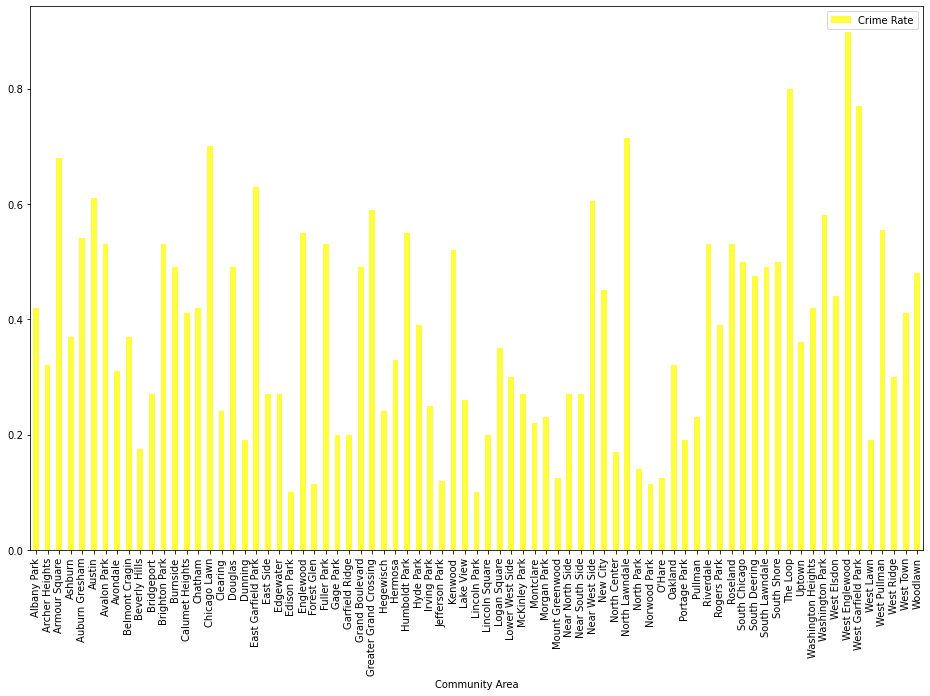

In [37]:
crime_rate.plot(kind='bar',figsize=(16,10),color='yellow',alpha=0.75)